
# MARS lander code for registering an correcting rotation and scaling

Based on https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_rotation.html



In [ ]:
%matplotlib widget

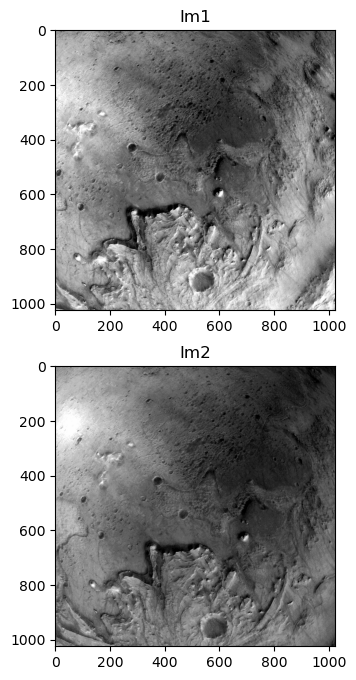

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float
from skimage.filters import window, difference_of_gaussians
from scipy.fft import fft2, fftshift, ifft2
from scipy.ndimage import fourier_shift
from skimage.util import compare_images
import os


In [ ]:
base_url= '/export/work/Satdata2/Mars_2020/pdsimg-atlas-curl_2025-01-23T07_35_26_167/edl/'
im1 = os.path.join(base_url,'ELM_0000_0666952837_600ECM_N0000020LVS_04000_0000LUJ01.png')
im2 = os.path.join(base_url,'ELM_0000_0666952841_000ECM_N0000021LVS_04000_0000LUJ01.png')

img1 = plt.imread(im1)

img2 = plt.imread(im2)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Im1")
ax[0].imshow(img1)
ax[1].set_title("Im2")
ax[1].imshow(img2)
plt.show()



## Recover rotation and scaling differences with log-polar transform

In this xample, the images differ by both rotation and scaling (note
the axis tick values). By remapping these images into log-polar space,
we can recover rotation and scaling, by phase correlation.

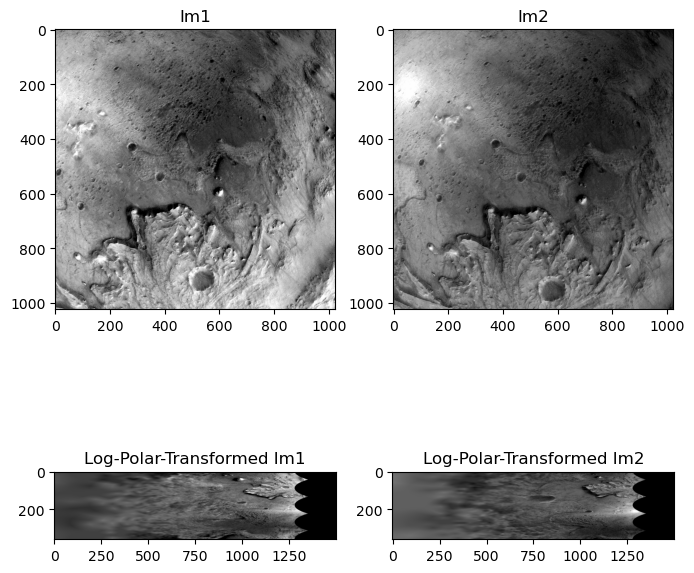

Expected value for cc rotation in degrees: 53.7
Recovered value for cc rotation: -0.05000000074505806

Expected value for scaling difference: 2.2
Recovered value for scaling difference: 0.9997562556939357


In [2]:
# radius must be large enough to capture useful info in larger image
radius = 1500
angle = 53.7
scale = 2.2

img1_polar = warp_polar(img1, radius=radius, scaling='log', channel_axis=2)
img2_polar = warp_polar(img2, radius=radius, scaling='log', channel_axis=2)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Im1")
ax[0].imshow(img1)
ax[1].set_title("Im2")
ax[1].imshow(img2)
ax[2].set_title("Log-Polar-Transformed Im1")
ax[2].imshow(img1_polar)
ax[3].set_title("Log-Polar-Transformed Im2")
ax[3].imshow(img2_polar)
plt.show()

# setting `upsample_factor` can increase precision
shifts, error, phasediff = phase_cross_correlation(
    img1_polar, img2_polar, upsample_factor=20, normalization=None
)
shiftr, shiftc = shifts[:2]

# Calculate scale factor from translation
klog = radius / np.log(radius)
shift_scale = 1 / (np.exp(shiftc / klog))

print(f'Expected value for cc rotation in degrees: {angle}')
print(f'Recovered value for cc rotation: {shiftr}')
print()
print(f'Expected value for scaling difference: {scale}')
print(f'Recovered value for scaling difference: {shift_scale}')

## Register rotation and scaling on a translated image - Part 1

The above examples only work when the images to be registered share a
center. However, it is more often the case that there is also a translation
component to the difference between two images to be registered. One
approach to register rotation, scaling and translation is to first correct
for rotation and scaling, then solve for translation. It is possible to
resolve rotation and scaling differences for translated images by working on
the magnitude spectra of the Fourier-transformed images.

In this next example, we first show how the above approaches fail when two
images differ by rotation, scaling, and translation.



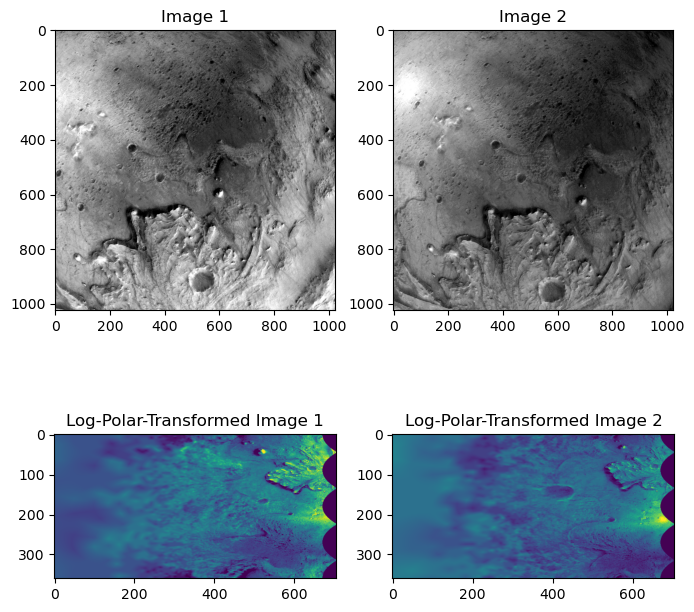

In [3]:
base_url= '/export/work/Satdata2/Mars_2020/pdsimg-atlas-curl_2025-01-23T07_35_26_167/edl/'
im1 = os.path.join(base_url,'ELM_0000_0666952837_600ECM_N0000020LVS_04000_0000LUJ01.png')
im2 = os.path.join(base_url,'ELM_0000_0666952841_000ECM_N0000021LVS_04000_0000LUJ01.png')

img1 = plt.imread(im1)
img1_org = plt.imread(im1)[:,:,0]
img1 = np.sum(img1,axis=2)

img2 = plt.imread(im2)
img2_org = plt.imread(im2)[:,:,0]
img2 = np.sum(img2,axis=2)

# When center is not shared, log-polar transform is not helpful!
radius = 705
img1_polar = warp_polar(img1, radius=radius, scaling="log")
img2_polar = warp_polar(img2, radius=radius, scaling="log")

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1, cmap='gray')
ax[1].set_title("Image 2")
ax[1].imshow(img2, cmap='gray')
ax[2].set_title("Log-Polar-Transformed Image 1")
ax[2].imshow(img1_polar)
ax[3].set_title("Log-Polar-Transformed Image 2")
ax[3].imshow(img2_polar)
plt.show()

## Register rotation and scaling on a translated image - Part 2

We next show how rotation and scaling differences, but not translation
differences, are apparent in the frequency magnitude spectra of the images.
These differences can be recovered by treating the magnitude spectra as
images themselves, and applying the same log-polar + phase correlation
approach taken above.



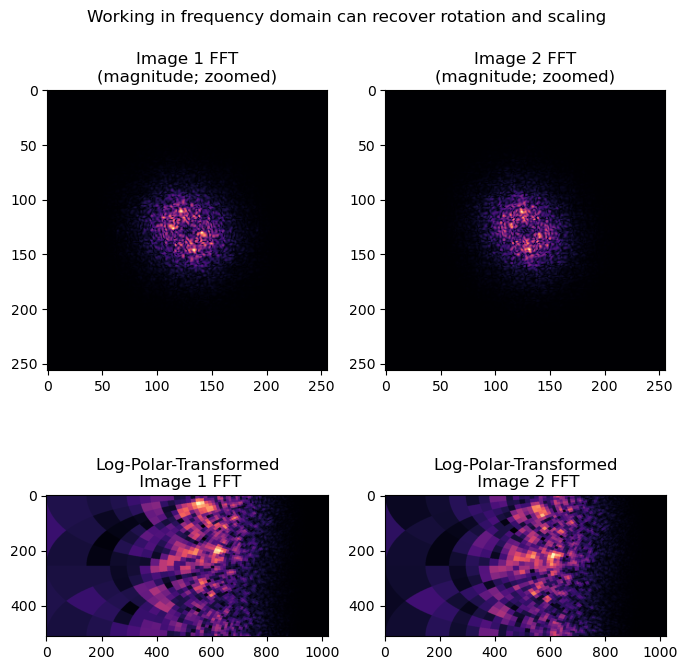

Recovered value for cc rotation: -5.80078125

Recovered value for scaling difference: 1.0500151590833693


In [4]:
# First, band-pass filter both images
img1 = difference_of_gaussians(img1, 5, 20)
img2 = difference_of_gaussians(img2, 5, 20)

# window images
img1_wi = img1 * window('hann', img1.shape)
img2_wi = img2 * window('hann', img2.shape)

# work with shifted FFT magnitudes
img1_fft = np.abs(fftshift(fft2(img1_wi)))
img2_fft = np.abs(fftshift(fft2(img2_wi)))

# Create log-polar transformed FFT mag images and register
shape = img1_fft.shape
radius = shape[0] // 8  # only take lower frequencies
warped_img1_fft = warp_polar(
    img1_fft, radius=radius, output_shape=shape, scaling='log', order=0
)
warped_img2_fft = warp_polar(
    img2_fft, radius=radius, output_shape=shape, scaling='log', order=0
)

warped_img1_fft = warped_img1_fft[: shape[0] // 2, :]  # only use half of FFT
warped_img2_fft = warped_img2_fft[: shape[0] // 2, :]
shifts, error, phasediff = phase_cross_correlation(
    warped_img1_fft, warped_img2_fft, upsample_factor=10, normalization=None
)

# Use translation parameters to calculate rotation and scaling parameters
shiftr, shiftc = shifts[:2]
recovered_angle = (360 / shape[0]) * shiftr
klog = shape[1] / np.log(radius)
shift_scale = np.exp(shiftc / klog)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Image 1 FFT\n(magnitude; zoomed)")
center = np.array(shape) // 2
ax[0].imshow(
    img1_fft[
        center[0] - radius : center[0] + radius, center[1] - radius : center[1] + radius
    ],
    cmap='magma',
)
ax[1].set_title("Image 2 FFT\n(magnitude; zoomed)")
ax[1].imshow(
    img2_fft[
        center[0] - radius : center[0] + radius, center[1] - radius : center[1] + radius
    ],
    cmap='magma',
)
ax[2].set_title("Log-Polar-Transformed\n Image 1 FFT")
ax[2].imshow(warped_img1_fft, cmap='magma')
ax[3].set_title("Log-Polar-Transformed\n Image 2 FFT")
ax[3].imshow(warped_img2_fft, cmap='magma')
fig.suptitle('Working in frequency domain can recover rotation and scaling')
plt.show()


print(f'Recovered value for cc rotation: {recovered_angle}')
print()
print(f'Recovered value for scaling difference: {shift_scale}')


## Some notes on this approach

It should be noted that this approach relies on a couple of parameters
that have to be chosen ahead of time, and for which there are no clearly
optimal choices:

1. The images should have some degree of bandpass filtering
applied, particularly to remove high frequencies, and different choices here
may impact outcome. The bandpass filter also complicates matters because,
since the images to be registered will differ in scale and these scale
differences are unknown, any bandpass filter will necessarily attenuate
different features between the images. For example, the log-polar transformed
magnitude spectra don't really look "alike" in the last example here. Yet if
you look closely, there are some common patterns in those spectra, and they
do end up aligning well by phase correlation as demonstrated.

2. Images must be windowed using windows with circular symmetry, to remove
the spectral leakage coming from image borders. There is no clearly optimal
choice of window.

Finally, we note that large changes in scale will dramatically alter the
magnitude spectra, especially since a big change in scale will usually be
accompanied by some cropping and loss of information content. The literature
advises staying within 1.8-2x scale change [1]_ [2]_. This is fine for most
biological imaging applications.

### References

.. [1] B.S. Reddy and B.N. Chatterji. An FFT-based technique for translation,
       rotation and scale- invariant image registration. IEEE Trans. Image
       Processing, 5(8):1266–1271, 1996. :DOI:`10.1109/83.506761`

.. [2] Tzimiropoulos, Georgios, and Tania Stathaki. "Robust FFT-based
       scale-invariant image registration." In 4th SEAS DTC Technical
       Conference. 2009. :DOI:`10.1109/TPAMI.2010.107`


## Below is the detected subpixel offset, and a demonstration of overlaying the image 

(1122, 1122)

<Figure size 640x480 with 0 Axes>

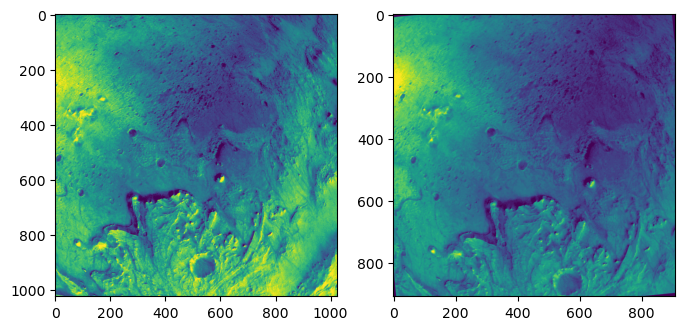

In [5]:

img2_cor = rotate(img2_org, -recovered_angle,resize=True)
display(img2_cor.shape)
img2_cor = rescale(img2_cor, 1/shift_scale)
N= 80
img2_cor = img2_cor[N:-N,N:-N]

plt.figure(10)
plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].imshow(img1_org)
ax[1].imshow(img2_cor)
plt.show()

(909, 909)

(909, 909)

Detected subpixel offset (y, x):
[ 53.6 -32.5]


Text(0.5, 1.0, 'Shifted image 2')

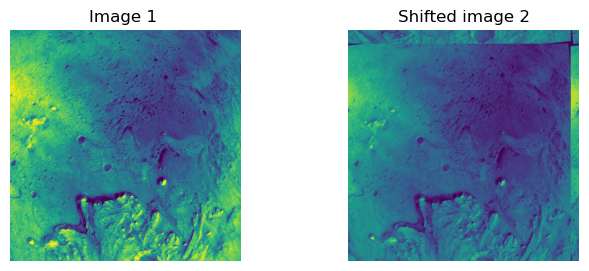

In [6]:
img1_org_crop = img1_org[0:img2_cor.shape[0],0:img2_cor.shape[1]]
display(img1_org_crop.shape, img2_cor.shape)

offset_image = img2_cor  
shift, error, diffphase = phase_cross_correlation(img1_org_crop, offset_image, upsample_factor=10)
print("Detected subpixel offset (y, x):")
print(shift)

shifted_image = np.abs(np.fft.ifft2(
    fourier_shift(np.fft.fft2(offset_image), shift)))

#shifted_image = np.zeros([offset_image.shape[0]+np.abs(shift[0]),
#                          offset_image.shape[1]+np.abs(shift[1]),
#                          offset_image.shape[2]])

#shifted_image[shift[0]:
# Rescale image 
shifted_image = shifted_image/np.max(shifted_image[:])*np.max(img2[:])
# Round the image to integers and convert to correct dtype
#shifted_image = np.around(shifted_image).astype(np.float32)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.imshow(img1_org_crop)
ax1.set_axis_off()
ax1.set_title('Image 1 ')

ax2.imshow(shifted_image)
ax2.set_axis_off()
ax2.set_title('Shifted image 2')

# Taking the difference in the images (using float to avoid problem with
# overflow)



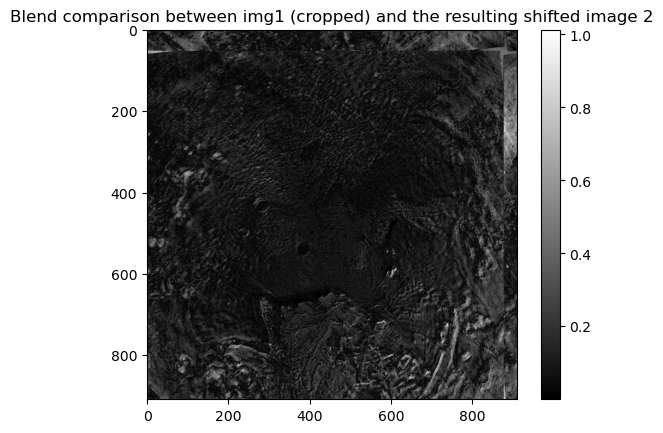

In [7]:
plt.figure(20)
plt.clf()
plt.imshow(compare_images(img1_org_crop, shifted_image, method='diff'), cmap='gray')
plt.title('Blend comparison between img1 (cropped) and the resulting shifted image 2')
plt.colorbar()
plt.show()